In [1]:
import torch
import torch.nn as nn
import torch_geometric.nn as geom_nn

# Use cuda if available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Torch device: %s" % (DEVICE))

Torch device: cuda


In [2]:
# Load connectome
connectome = torch.load('/home/lrvnc/Projects/worm-graph/data/processed/connectome/graph_tensors.pt')

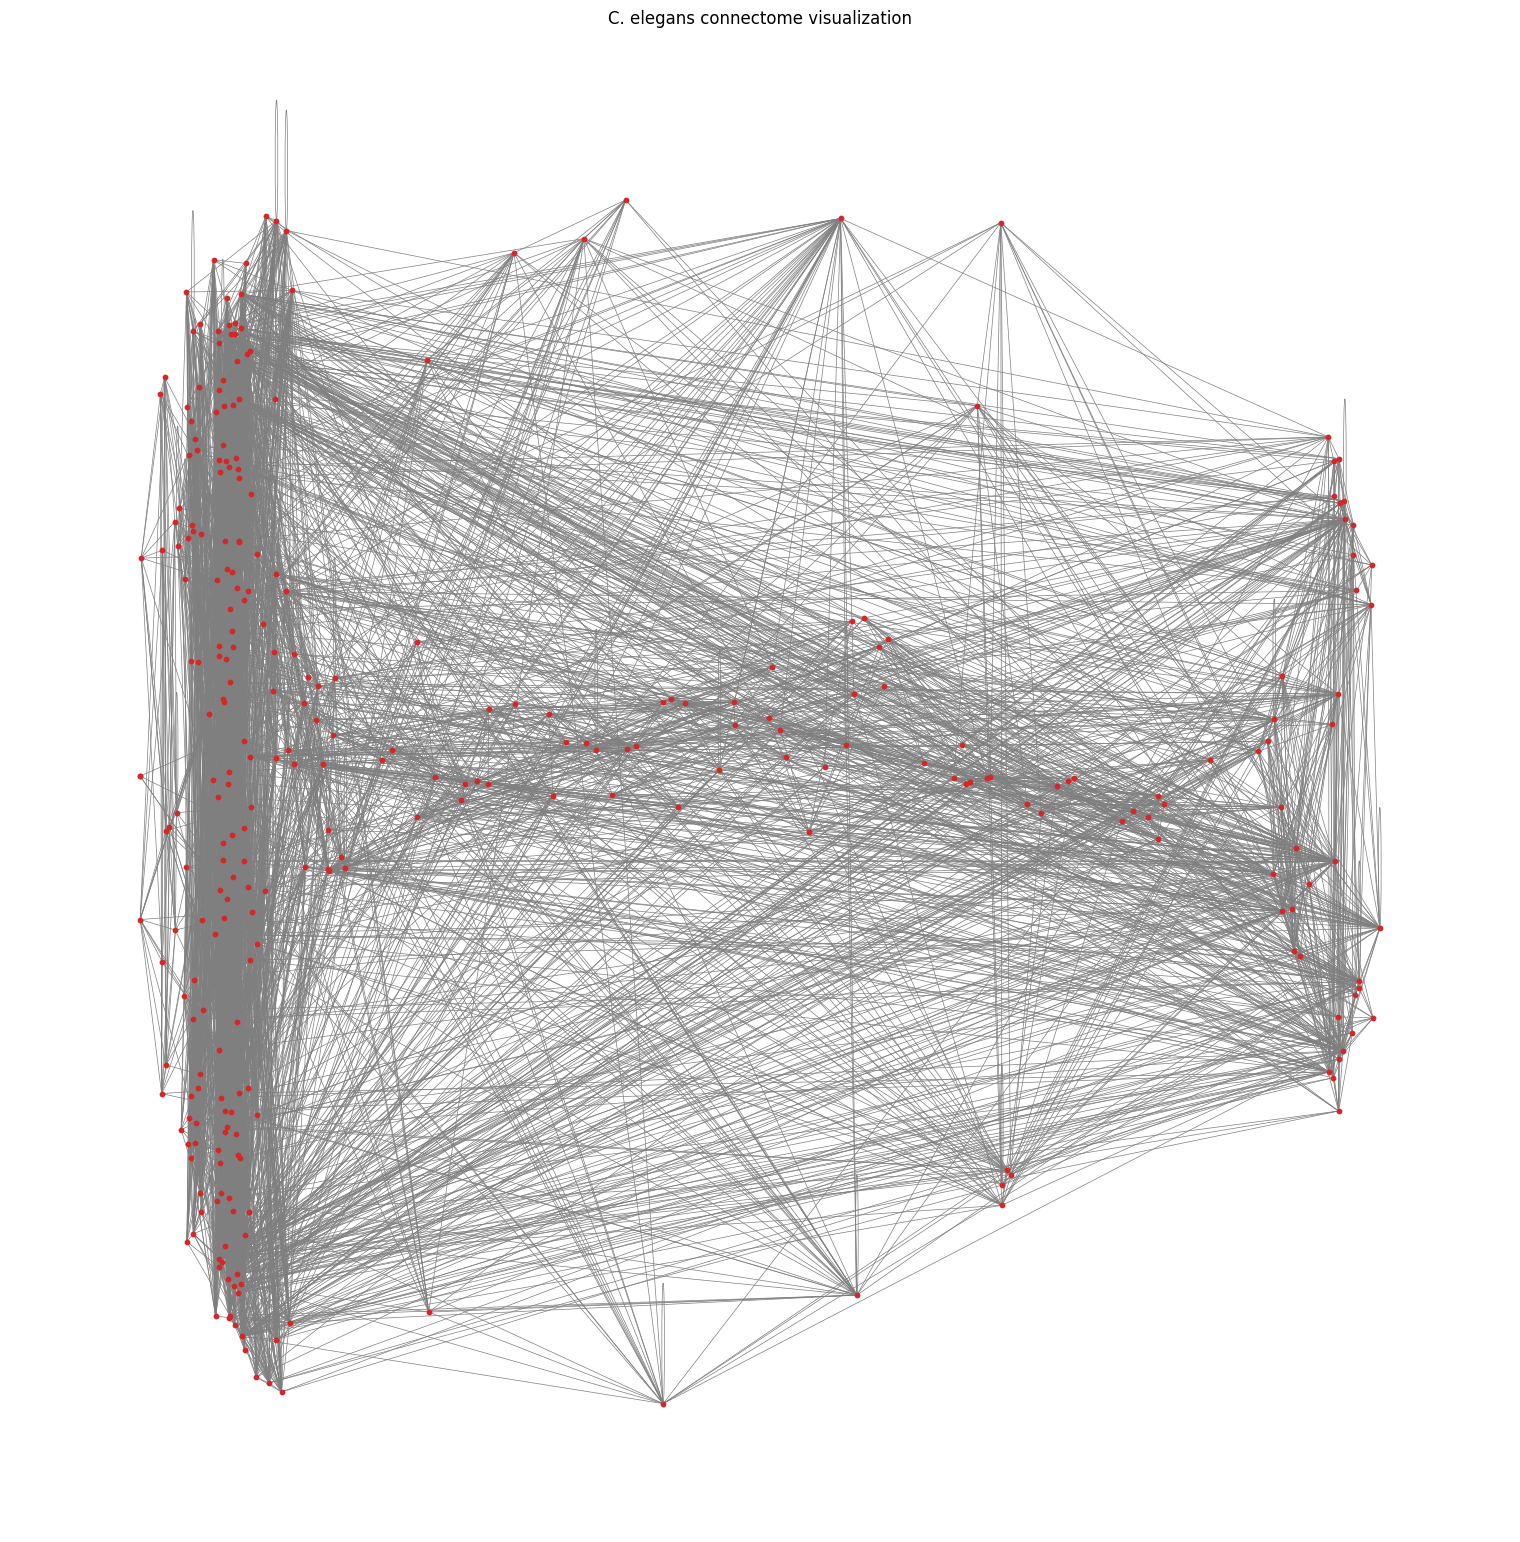

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

edges = list(zip(connectome['edge_index'][0].tolist(), connectome['edge_index'][1].tolist()))

G = nx.Graph()
G.add_edges_from(edges)

# Using spring layout for visualization
pos = nx.spring_layout(G)
pos = connectome['pos']

plt.figure(figsize=(15, 15))  # Adjust as needed
nx.draw(G, pos, with_labels=False, node_size=10, node_color="tab:red", edge_color="tab:grey", width=0.5)
plt.title("C. elegans connectome visualization")
plt.show()


In [ ]:
class NeuralActivityPredictor(nn.Module):
    def __init__(self, num_neurons, gnn_hidden_dim, rnn_hidden_dim, seq_len):
        super(NeuralActivityPredictor, self).__init__()
        self.gnn = geom_nn.GCNConv(num_neurons, gnn_hidden_dim)
        self.rnn = nn.LSTM(gnn_hidden_dim, rnn_hidden_dim, batch_first=True)
        self.predictor = nn.Linear(rnn_hidden_dim, num_neurons)
        self.seq_len = seq_len

    def forward(self, X, edge_index):
        # Spatial feature update with GNN
        spatial_out = self.gnn(X, edge_index)

        # Reshape spatial_out for RNN's input [batch, seq_len, features]
        # Assuming spatial_out has shape [batch * seq_len, features]
        spatial_out = spatial_out.view(spatial_out.size(0) // self.seq_len, self.seq_len, -1)
        
        # Temporal feature update with RNN
        rnn_out, _ = self.rnn(spatial_out)

        # Prediction for the next timestep
        out = self.predictor(rnn_out[:, -1, :])
        return out

# Create model instance, define optimizer and loss function, then train.
